# AN2DL - Homework 1

## 1 - Libraries and Dataset Import

In [12]:
# In this notebook you will only find comments related to new/modified code
# Please refere to our notebooks FORmidable_basic_model and FORmidable_MNV3_light_custom for all commented sections
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import cv2
import os

os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
import keras as tfk
from keras import layers as tfkl
from keras_cv import layers as kcvl
from keras import mixed_precision

tf.config.optimizer.set_jit(True)

print("GPUs Available: ", tf.config.list_physical_devices('GPU'))
print(f"TensorFlow version {tf.__version__}")

np.random.seed(42)
tf.random.set_seed(42)

GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
TensorFlow version 2.16.1


In [2]:
import tensorflow as tf
from keras_cv import layers as kcvl
from tensorflow.keras.layers import Resizing # type: ignore
import matplotlib.pyplot as plt

# Augmentation pipeline parameters
value_range = (0, 255)  # Range of pixel values in the images

# Define the augmentation layers
enhancement_layers = [
    kcvl.RandAugment(value_range=value_range, magnitude=0.2, magnitude_stddev=0.2),
    kcvl.GridMask(ratio_factor=0.4),
    kcvl.RandomSharpness(factor=0.2, value_range=value_range)
]

# Custom function to add Gaussian noise
def add_gaussian_noise(images, mean=0.0, stddev=20):
    noise = tf.random.normal(shape=tf.shape(images), mean=mean, stddev=stddev, dtype=tf.float32)
    noisy_images = images + noise
    return tf.clip_by_value(noisy_images, 0.0, 255.0)

# Define the augmentation pipeline
pipeline = kcvl.RandomAugmentationPipeline(
    layers=enhancement_layers,
    augmentations_per_image=4
)

def apply_pipeline(inputs):
    inputs["images"] = pipeline(inputs["images"])  # Apply RandomAugmentationPipeline
    inputs["images"] = add_gaussian_noise(inputs["images"])  # Add custom Gaussian Noise
    return inputs

# Function to plot augmented images for visualization
def plot_augmented_images(X_train, y_train, num_images, num_augmentations=4):
    batch = X_train[:num_images]  # Take a batch of images for visualization
    labels_batch = y_train[:num_images]

    fig, axes = plt.subplots(num_augmentations + 1, num_images, figsize=(20, 10))  # 4 rows, 10 columns

    # Display original images in the first row
    for i in range(num_images):
        original_image = batch[i].astype("uint8")  # Convert to uint8 for display
        axes[0, i].imshow(original_image)
        axes[0, i].axis("off")
        if i == 0:
            axes[0, i].set_title("Original", fontsize=12)
        else:
            axes[0, i].set_title("")

    # Display augmentations in subsequent rows
    for j in range(num_augmentations):
        augmented_batch = apply_pipeline({
            "images": tf.convert_to_tensor(batch),
            "labels": tf.convert_to_tensor(labels_batch, dtype=tf.float32)
        })
        for i in range(num_images):
            augmented_image = tf.clip_by_value(augmented_batch["images"][i], 0, 255)  # Ensure values are in display range
            axes[j + 1, i].imshow(augmented_image.numpy().astype("uint8"))
            axes[j + 1, i].axis("off")
            if i == 0:
                axes[j + 1, i].set_title(f"Augmentation {j + 1}", fontsize=12)
            else:
                axes[j + 1, i].set_title("")

    plt.tight_layout()
    plt.show()

# Function to create the training dataset pipeline with augmentation and normalization
def create_train_dataset(X_train, y_train, batch_size, target_size):
    normalization = 127.5
    range = 1
    resize_layer = Resizing(target_size[0], target_size[1], interpolation='bicubic')

    train_dataset = (
        tf.data.Dataset.from_tensor_slices((X_train, y_train))
        .batch(batch_size)
        .map(lambda x, y: (apply_pipeline({"images": x, "labels": tf.cast(y, tf.float32)})["images"], y), num_parallel_calls=tf.data.AUTOTUNE)
        .map(lambda x, y: (resize_layer(x), y), num_parallel_calls=tf.data.AUTOTUNE)  # Apply bicubic resizing
        .map(lambda x, y: ((x / normalization) - range, y), num_parallel_calls=tf.data.AUTOTUNE)  # Normalize images
        .prefetch(tf.data.AUTOTUNE)
    )
    return train_dataset

# Function to create the validation dataset pipeline with resizing and normalization
def create_val_dataset(X_val, y_val, batch_size, target_size):
    normalization = 127.5
    range = 1
    resize_layer = Resizing(target_size[0], target_size[1], interpolation='bicubic')

    val_dataset = (
        tf.data.Dataset.from_tensor_slices((X_val, y_val))
        .batch(batch_size)
        .map(lambda x, y: (resize_layer(x), y), num_parallel_calls=tf.data.AUTOTUNE)  # Apply bicubic resizing
        .map(lambda x, y: ((x / normalization) - range, y), num_parallel_calls=tf.data.AUTOTUNE)  # Normalize images
        .prefetch(tf.data.AUTOTUNE)
    )
    return val_dataset

In [3]:
data = np.load('/kaggle/input/hmw1-original-dset/training_set.npz')

X = data['images']
y = data['labels']
print(X.shape, y.shape)

(13759, 96, 96, 3) (13759, 1)


## 2 - Checking for missing, duplicate values and class distribution

In [4]:
missing_targets = np.isnan(y.flatten()).any()

if not missing_targets :
    print("There are no missing or NaN values in the target vector.")

There are no missing or NaN values in the target vector.


In [5]:
# Duplicates count and removal
reshaped_X = X.reshape(X.shape[0], -1)
unique_X, unique_indices = np.unique(reshaped_X, axis=0, return_index=True)

X_unique = X[unique_indices]
y_unique = y[unique_indices]

print(f'Labels reduced from {len(y)} to {len(y_unique)}')

X = X_unique
y = y_unique

Labels reduced from 13759 to 11953


In [22]:
labels = {0:'Basophil', 1:'Eosinophil', 2:'Erythroblast', 3:'Immature granulocytes', 4:'Lymphocyte', 5:'Monocyte', 6:'Neutrophil', 7:'Platelet'}

# Class plotting already shown in FORmidable_basic_model notebook
''''''

''

## 3 - Split dataset into Train, Test and Validation sets while maintaining the distribution

In [10]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, stratify=y_train_val)

print("Training Data Shape:", X_train.shape)
print("Training Label Shape:", y_train.shape)
print("Test Data Shape:", X_test.shape)
print("Test Label Shape:", y_test.shape)
print("Validation Data Shape:", X_val.shape)
print("Validation Label Shape:", y_val.shape)

y_train = tfk.utils.to_categorical(y_train)
y_val = tfk.utils.to_categorical(y_val)
y_test = tfk.utils.to_categorical(y_test)

Training Data Shape: (8605, 96, 96, 3)
Training Label Shape: (8605, 1)
Test Data Shape: (2391, 96, 96, 3)
Test Label Shape: (2391, 1)
Validation Data Shape: (957, 96, 96, 3)
Validation Label Shape: (957, 1)


## 4 - Image Augmentation

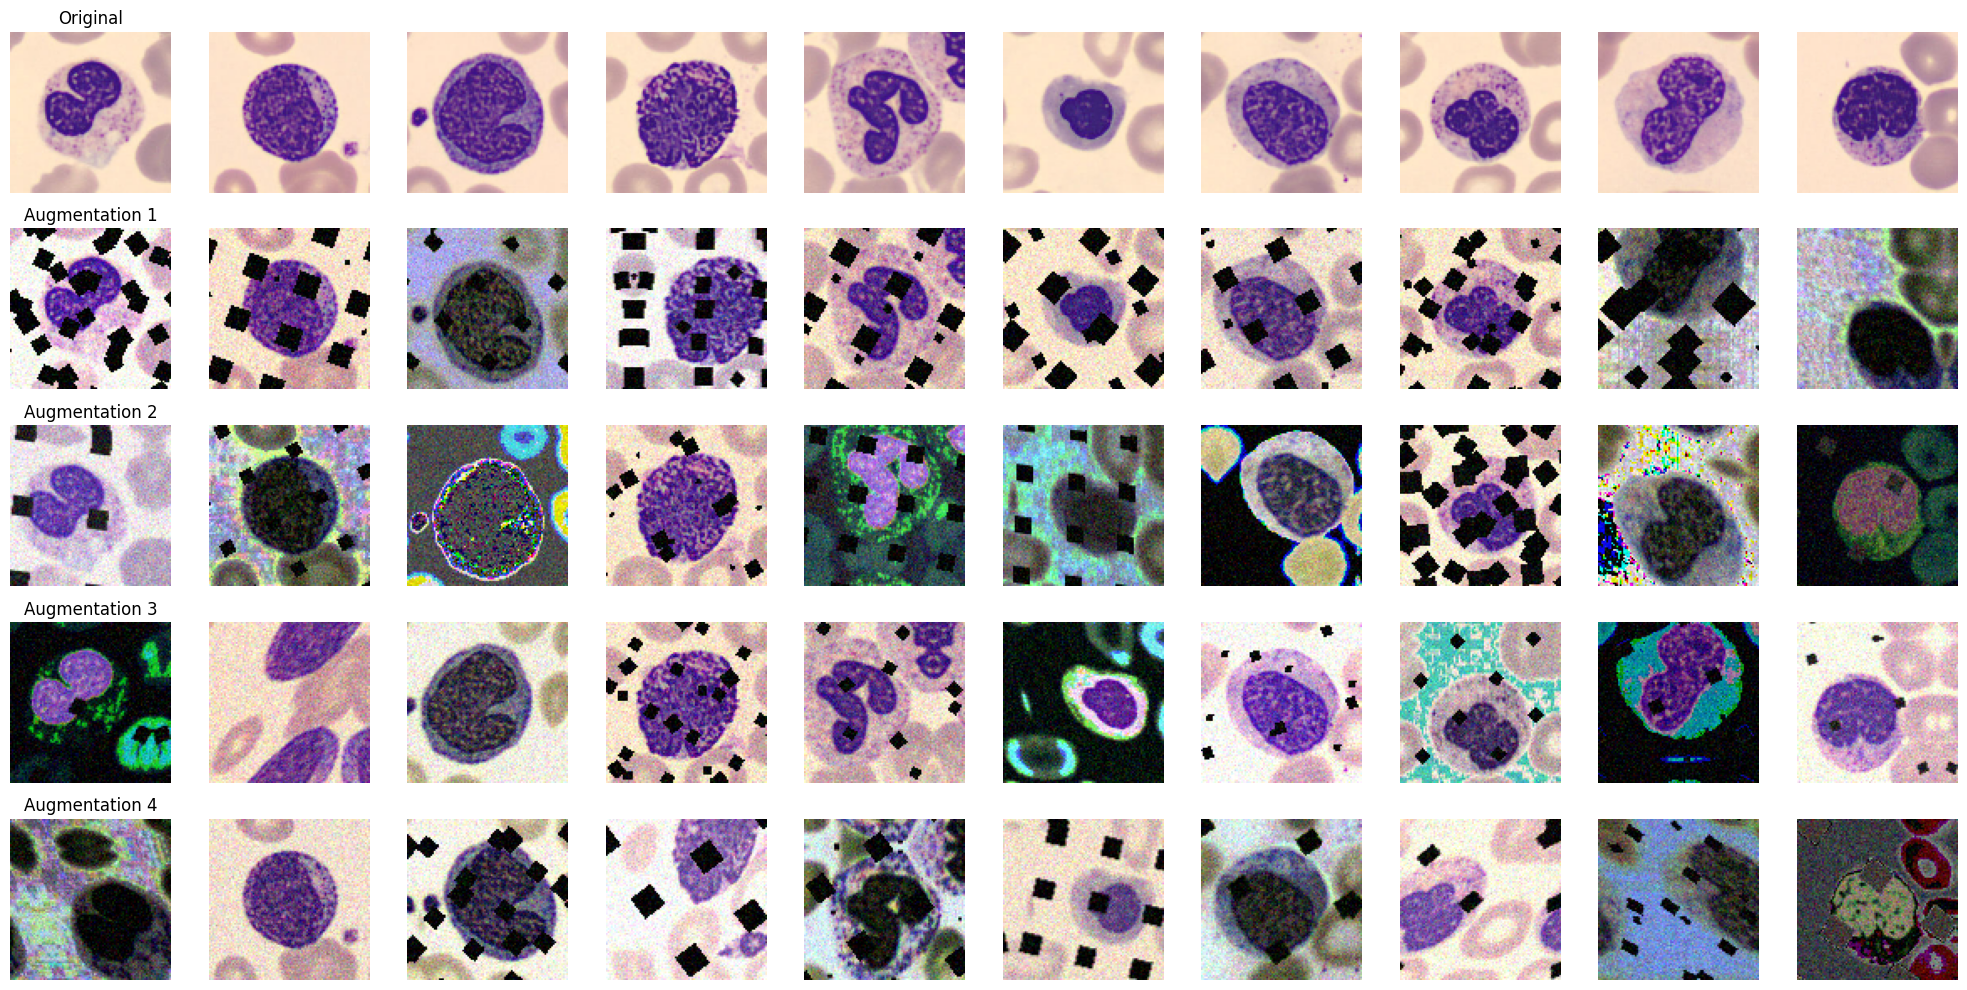

In [13]:
batch_size = 32
target_size = (96, 96)  # No resizing applied to a custom model

plot_augmented_images(X_train, y_train, num_images=10)

train_dataset = create_train_dataset(X_train, y_train, batch_size, target_size)
val_dataset = create_val_dataset(X_val, y_val, batch_size, target_size)

# 5. Training

In [14]:
mixed_precision.set_global_policy('mixed_float16')

block_config = [ # Our only change from the previous notebook (FORmidable_MNV3_light_custom) resides in the number of filters and stacks:
    {"filters": 32, "stack": 2, "downsample": False}, 
    {"filters": 64, "stack": 3, "downsample": True},  
    {"filters": 128, "stack": 4, "downsample": True},  
    {"filters": 256, "stack": 5, "downsample": True}, 
    {"filters": 512, "stack": 5, "downsample": False}, 
    {"filters": 1024, "stack": 5, "downsample": True}, 
]

In [15]:
for batch_images, batch_labels in train_dataset.take(1):
    print("Train batch images shape:", batch_images.shape)
    print("Train batch labels shape:", batch_labels.shape)
    input_shape = batch_images.shape[1:]
    output_shape = batch_labels.shape[1]
    print("Input Shape:", input_shape)
    print("Output Shape:", output_shape)

initial_learning_rate = 1e-5

Train batch images shape: (32, 96, 96, 3)
Train batch labels shape: (32, 8)
Input Shape: (96, 96, 3)
Output Shape: 8


## Weighted loss to help model differentiate between closest classes
After identifying that some classes were harder to classify thanks to both our previous confusion matrices and to the PCA visualization, we decided to try a custom loss : a weighted version of the Categorical Crossentropy. The hardest the class is to identify, the highest her weight in the loss. This should enforce the model to put more effort in identifying those classes.

In [16]:
from tensorflow.keras.losses import Loss
import keras
from tensorflow.keras import backend as K

@keras.saving.register_keras_serializable()
class WeightedCategoricalCrossentropy(tf.keras.losses.Loss):
    def __init__(self, class_weights=None, name="weighted_categorical_crossentropy"):
        """
        Custom loss function for weighted categorical crossentropy.
        
        Args:
        - class_weights (list or tensor, optional): A list or tensor of weights for each class.
        - name (str, optional): Name of the loss function.
        """
        super(WeightedCategoricalCrossentropy, self).__init__(name=name)
        
        if class_weights is not None:
            self.class_weights = tf.convert_to_tensor(class_weights, dtype=tf.float32)
        else:
            self.class_weights = None

    def call(self, y_true, y_pred):
        """
        Computes the weighted categorical crossentropy between true labels and predictions.
        
        Args:
        - y_true: Ground truth labels.
        - y_pred: Predicted probabilities.
        
        Returns:
        - loss: Weighted categorical crossentropy loss value.
        """
        # Clip predictions to prevent log(0) errors
        y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())
        
        # Compute the categorical crossentropy
        crossentropy = -K.sum(y_true * K.log(y_pred), axis=-1)
        
        if self.class_weights is not None:
            # Apply the class weights
            weights = K.sum(self.class_weights * y_true, axis=-1)
            loss = crossentropy * weights
        else:
            loss = crossentropy
        
        return K.mean(loss)

# Define class weights (higher for hard to differentiate classes : Immature Granulocytes and Neutrophils)
class_weights = [1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.5, 1.0]
loss_fn = WeightedCategoricalCrossentropy(class_weights=class_weights)

In [16]:
def mobilenetv3_block(x, filters, kernel_size=3, padding='same',
                      downsample=True, activation='h_swish', stack=1, name='mobilev3'):

    def h_swish(x):
        return x * tf.nn.relu6(x + 3.0) / 6.0

    activation_fn = tf.nn.relu if activation == 'relu' else h_swish

    for s in range(stack):
        input_channels = x.shape[-1]
        residual = x

        expansion_factor = 1 if input_channels == filters else 6
        expanded_channels = input_channels * expansion_factor

        if expansion_factor != 1:
            x = tfkl.Conv2D(expanded_channels, 1, padding=padding, use_bias=False, name=f'{name}_expand_{s}')(x)
            x = tfkl.BatchNormalization(name=f'{name}_bn1_{s}')(x)
            x = tfkl.Activation(activation_fn, name=f'{name}_act1_{s}')(x)

        stride = 2 if (downsample and s == 0) else 1
        x = tfkl.DepthwiseConv2D(kernel_size, strides=stride, padding=padding, use_bias=False, name=f'{name}_depthwise_{s}')(x)
        x = tfkl.BatchNormalization(name=f'{name}_bn2_{s}')(x)
        x = tfkl.Activation(activation_fn, name=f'{name}_act2_{s}')(x)

        se_channels = max(1, expanded_channels // 4)
        se = tfkl.GlobalAveragePooling2D(name=f'{name}_se_pool_{s}')(x)
        se = tfkl.Reshape((1, 1, expanded_channels))(se)
        se = tfkl.Conv2D(se_channels, 1, activation='relu', name=f'{name}_se_reduce_{s}')(se)
        se = tfkl.Conv2D(expanded_channels, 1, activation='hard_sigmoid', name=f'{name}_se_expand_{s}')(se)
        x = tfkl.Multiply(name=f'{name}_se_excite_{s}')([x, se])

        x = tfkl.Conv2D(filters, 1, padding=padding, use_bias=False, name=f'{name}_project_{s}')(x)
        x = tfkl.BatchNormalization(name=f'{name}_bn3_{s}')(x)

        if stride == 1 and input_channels == filters:
            x = tfkl.Add(name=f'{name}_add_{s}')([residual, x])

    return x

input_layer = tfkl.Input(shape=input_shape, name='input_layer')
x = input_layer

for i, config in enumerate(block_config):
    x = mobilenetv3_block(
        x=x, 
        filters=config["filters"], 
        kernel_size=3,
        downsample=config["downsample"], 
        stack=config["stack"], 
        name=f'block_{i}'
    )

x = tfkl.GlobalAveragePooling2D(name='gap')(x)
x = tfkl.Dense(output_shape, name='dense')(x)
x = tfkl.Activation('softmax', name='softmax')(x)

model = tfk.Model(inputs=input_layer, outputs=x, name='Custom_heavy_MobileNetV3_architecture')
model.compile(loss=loss_fn, optimizer=tf.keras.optimizers.Lion(learning_rate=initial_learning_rate), metrics=['accuracy'])

In [19]:
epochs = 1000 # Setting a high number to allow for early stopping

early_stopping = tfk.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
reduce_lr = tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)

In [20]:
# Please note that the output of this cell shows a high accuracy from the beginning because it was executed
# on a model previously trained by us (with the exact same hyperparameters and loss function). This is just to show that we
# indeed trained it ourselves from the beginning.
start_time = time.time()

history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset,
    callbacks=[early_stopping, reduce_lr]
    ).history

print("--- %s seconds ---" % (time.time() - start_time))

final_val_accuracy = round(max(history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

#model_filename = 'FinalSubmissions/MNV3_heavy_custom.keras'
#print('Saving to', model_filename)
#model.save(model_filename)

Epoch 1/1000


I0000 00:00:1732460544.083414     101 service.cc:145] XLA service 0x5ab7dfd5af40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732460544.083476     101 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1732460544.083482     101 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1732460544.180371     101 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


269/269 ━━━━━━━━━━━━━━━━━━━━ 260s 602ms/step - accuracy: 0.8914 - loss: 0.3630 - val_accuracy: 0.9749 - val_loss: 0.0955 - learning_rate: 1.0000e-05
Epoch 2/1000
269/269 ━━━━━━━━━━━━━━━━━━━━ 106s 368ms/step - accuracy: 0.8942 - loss: 0.3881 - val_accuracy: 0.9760 - val_loss: 0.1049 - learning_rate: 1.0000e-05
Epoch 3/1000
269/269 ━━━━━━━━━━━━━━━━━━━━ 105s 364ms/step - accuracy: 0.8928 - loss: 0.3649 - val_accuracy: 0.9812 - val_loss: 0.0799 - learning_rate: 1.0000e-05
Epoch 4/1000
269/269 ━━━━━━━━━━━━━━━━━━━━ 109s 379ms/step - accuracy: 0.8988 - loss: 0.3529 - val_accuracy: 0.9801 - val_loss: 0.0774 - learning_rate: 1.0000e-05
Epoch 5/1000
269/269 ━━━━━━━━━━━━━━━━━━━━ 107s 369ms/step - accuracy: 0.8975 - loss: 0.3493 - val_accuracy: 0.9791 - val_loss: 0.0762 - learning_rate: 1.0000e-05
Epoch 6/1000
269/269 ━━━━━━━━━━━━━━━━━━━━ 141s 365ms/step - accuracy: 0.8998 - loss: 0.3585 - val_accuracy: 0.9781 - val_loss: 0.0853 - learning_rate: 1.0000e-05
Epoch 7/1000
269/269 ━━━━━━━━━━━━━━━━━━━━

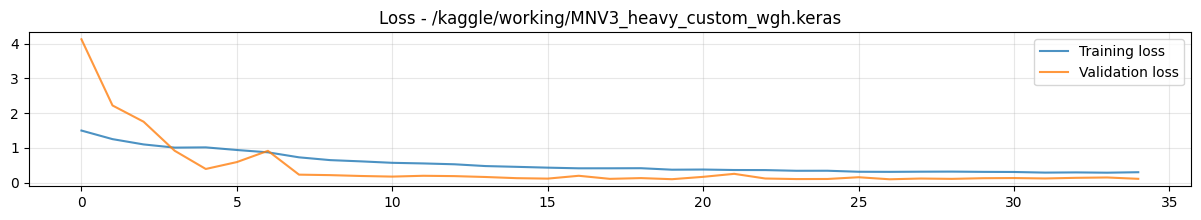

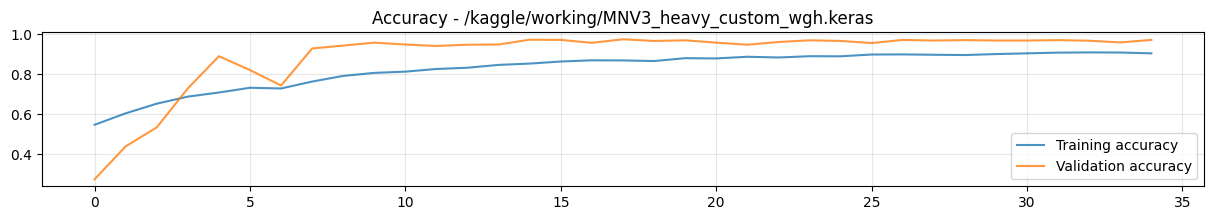

In [34]:
plt.figure(figsize=(15, 2))
plt.plot(history['loss'], label='Training loss', alpha=.8)
plt.plot(history['val_loss'], label='Validation loss', alpha=.8)
plt.title(f'Loss - {model_filename}')
plt.legend()
plt.grid(alpha=.3)

plt.figure(figsize=(15, 2))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8)
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.8)
plt.title(f'Accuracy - {model_filename}')
plt.legend()
plt.grid(alpha=.3)
plt.show()

# 6. Evaluating the model

(2391, 96, 96, 3) (2391, 8)
Predictions Shape: (2391, 8)
Accuracy score over the test set: 0.9762
Precision score over the test set: 0.9768
Recall score over the test set: 0.9762
F1 score over the test set: 0.9762


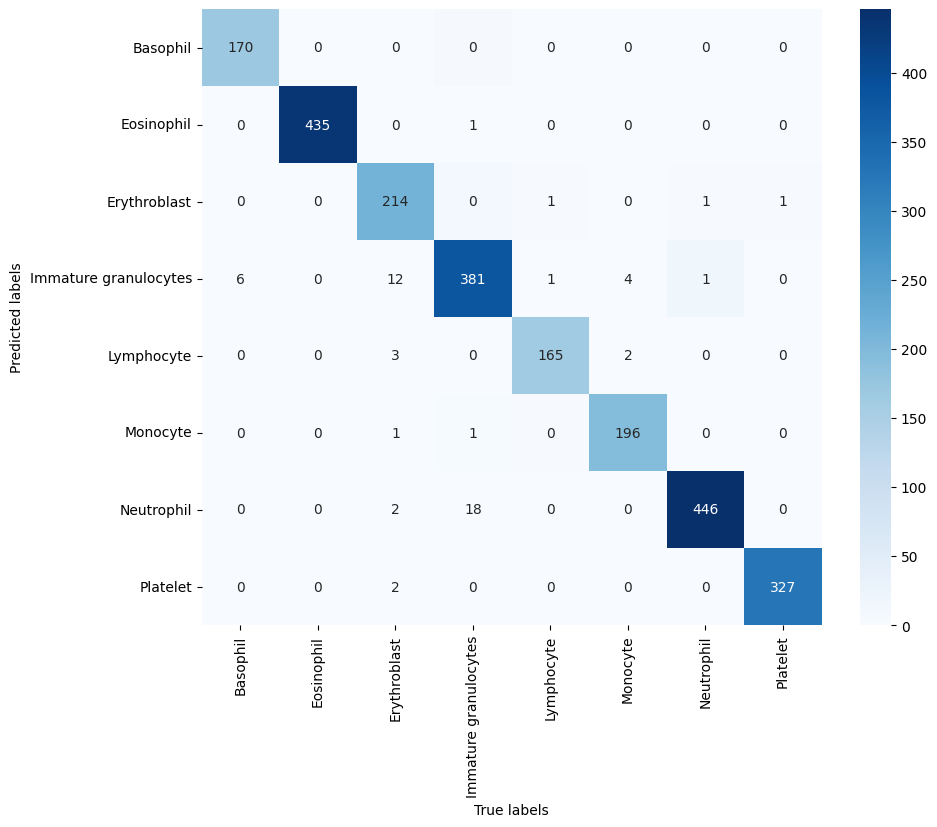

In [23]:
def h_swish(x): # Our custom object to be included in load_model
    return x * tf.nn.relu6(x + 3.0) / 6.0

# Apply normalization and resizing to the test data directly, as done in the model.py submission file
X_normalized = (X_test / 127.5).astype('float32') - 1
X_resized = np.array([cv2.resize(img, target_size, interpolation=cv2.INTER_CUBIC) for img in X_normalized])
print(X_resized.shape, y_test.shape)

predictions = model.predict(X_resized, verbose=0)

print("Predictions Shape:", predictions.shape)

pred_classes = np.argmax(predictions, axis=-1)
true_classes = np.argmax(y_test, axis=-1)

accuracy = accuracy_score(true_classes, pred_classes)
print(f'Accuracy score over the test set: {round(accuracy, 4)}')

precision = precision_score(true_classes, pred_classes, average='weighted')
print(f'Precision score over the test set: {round(precision, 4)}')

recall = recall_score(true_classes, pred_classes, average='weighted')
print(f'Recall score over the test set: {round(recall, 4)}')

f1 = f1_score(true_classes, pred_classes, average='weighted')
print(f'F1 score over the test set: {round(f1, 4)}')

cm = confusion_matrix(true_classes, pred_classes)

annot = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, annot=annot, fmt='', xticklabels=list(labels.values()), yticklabels=list(labels.values()), cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()